# (2) Plot Repeat Track Elevations of ATL06 Data and Anomalies 

**Author:** Bryony Freer

**Date Published:** 31 May 2023

**Inputs**: 

User defined:
- Directory containing ATL06 and Modelled tide files for region of interest
- Reference Ground Track (e.g. '0301')
- Reference Pair Track (1/2/3) 
- Coordinates for tide calculation 



**Output:** 
- Plots cross-track slope corrected repeat track elevations over a single ICESat-2 Track 
- Modelled tide heights for each repeat (cycle) given (CATS2008)
- Plots elevation anomalies per repeat cycle


### 1. Imports 

In [3]:
import glob
import os
import sys
import re
import pyproj
import datetime as dt
import numpy as np
from numpy import arange, array, nonzero, in1d, abs, linspace, sqrt, pi
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import pandas as pd
import h5py
import pyproj
import gdal 
import osr
from scipy.interpolate import interp1d
from scipy import interpolate

try:
    import pointCollection as pc
except Exception:
    !python3 -m pip install --user git+https://github.com/smithb/pointCollection.git
    import pointCollection as pc

import ipywidgets as widgets
from IPython.display import HTML

from pyTMD.read_tide_model import extract_tidal_constants
from pyTMD.read_netcdf_model import extract_netcdf_constants
from pyTMD.read_GOT_model import extract_GOT_constants
from pyTMD.read_FES_model import extract_FES_constants
from pyTMD.compute_tide_corrections import compute_tide_corrections

from ATL06_functions_published import create_color_dict, atl06_to_dict, min_seg_difference, PlotCorrectedRepeatTracks, ExtractData, find_nearest, extract_bed_h, GenerateNewLats, CalculateFits, PlotElevProfile, PlotElevAnom, CombinedFigure  

# run matplotlib in 'widget' mode
%matplotlib widget
%load_ext autoreload
%autoreload 2
matplotlib.rcParams['axes.linewidth'] = 2.0

### 2. User Input

- Study region location name 
- Path to directory containing ATL06 files for the study region 
- Path to directory to output results 
- XY coordinates of single point for tide calculation


In [8]:
# USER INPUT: Specify paths to folder containing ATL06 files
region = 'FRIS' 
root = '' #Path to directory containing data and outputs
data_root = root + 'data/' #Directory containing ATL06 files
outdir = root + 'results/' #Directory to output figures 
cycles_dir = root + 'results/used_cycles/' #Directory to output used_cycles.csv files per rgt

if not os.path.isdir(data_root):
    os.makedirs(data_root)
if not os.path.isdir(outdir):
    os.makedirs(outdir)
if not os.path.isdir(cycles_dir):
    os.makedirs(cycles_dir)
    
# Set consistent colour dictionary for different cycles (currently up to Cycle 17)
color_dict = create_color_dict()

matplotlib.rc_file_defaults()

### 3. Plot Elevation Profiles and Anomalies (against mean / lowest / neutral reference profile)

1. Specify RGT, RPT and left or right beam (lr) 
2. Call PlotCorrectedRepeatTracks() 
3. Determine cycles to use in RTLA analysis. Uses 50% data threshold, and can manually add or remove here. 
4. Call the ExtractData() function to make dicts of repeat track information, tides etc. 
5. Call CalculateFits() function 
6. Plotting (various options) 

**Note: It may be necessary to manually adjust certain cycles to ignore, see USER INPUT section of code.**

Using lowest tide cycle as reference profile
filename=../sample_data/FRIS/data\processed_ATL06_20200502042014_05590711_005_01.h5, exception='Unable to open object (component not found)'
Cycles to Use:  ['04', '06', '08', '09', '11', '12', '13']
Cycles Used for Mean:  ['09']
filename=../sample_data/FRIS/data\processed_ATL06_20200502042014_05590711_005_01.h5, exception='Unable to open object (component not found)'
Cycles to Use:  ['04', '06', '08', '09', '11', '12', '13']
Cycles Used for Mean:  ['09']
filename=../sample_data/FRIS/data\processed_ATL06_20200502042014_05590711_005_01.h5, exception='Unable to open object (component not found)'
Cycles to Use:  ['04', '06', '08', '09', '11', '12', '13']
Cycles Used for Mean:  ['09']
filename=../sample_data/FRIS/data\processed_ATL06_20200502042014_05590711_005_01.h5, exception='Unable to open object (component not found)'
Cycles to Use:  ['04', '06', '08', '09', '11', '12', '13']
Cycles Used for Mean:  ['09']
filename=../sample_data/FRIS/data\p

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
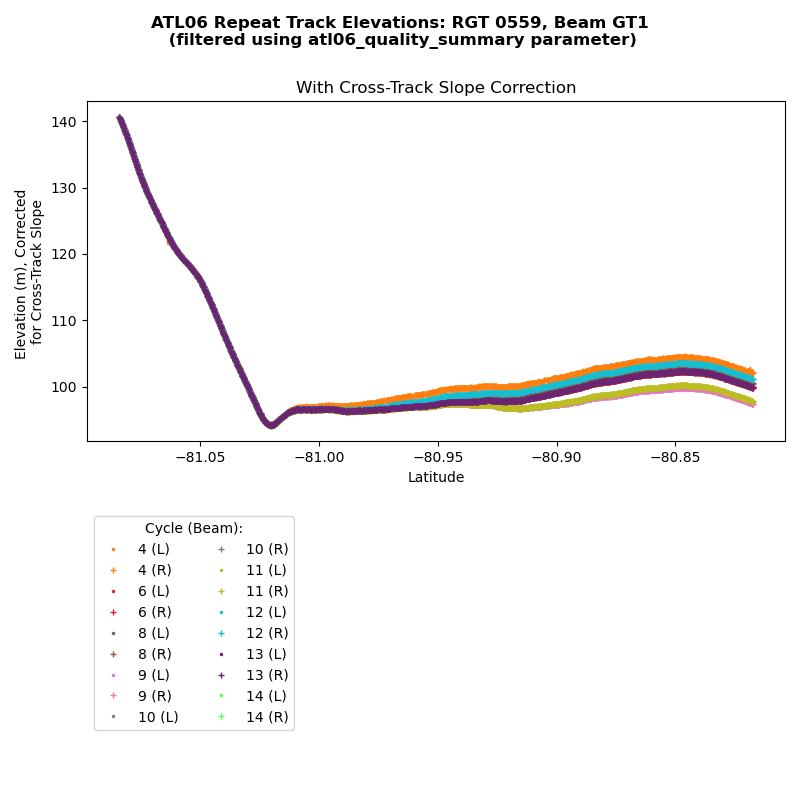

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
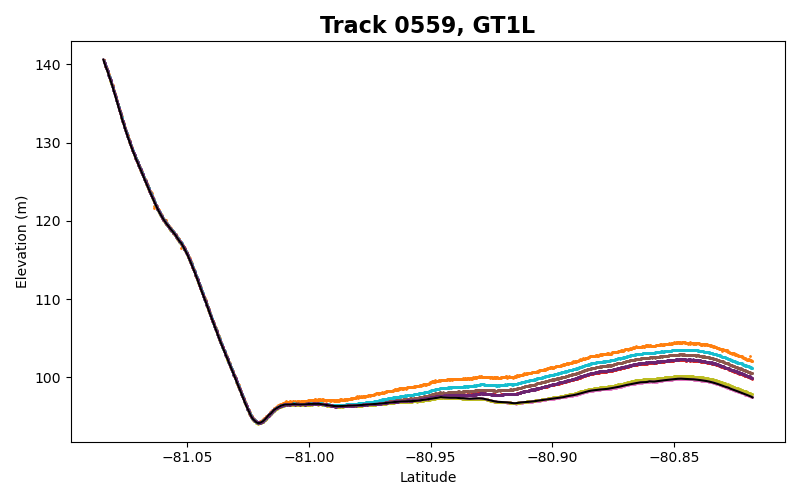

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
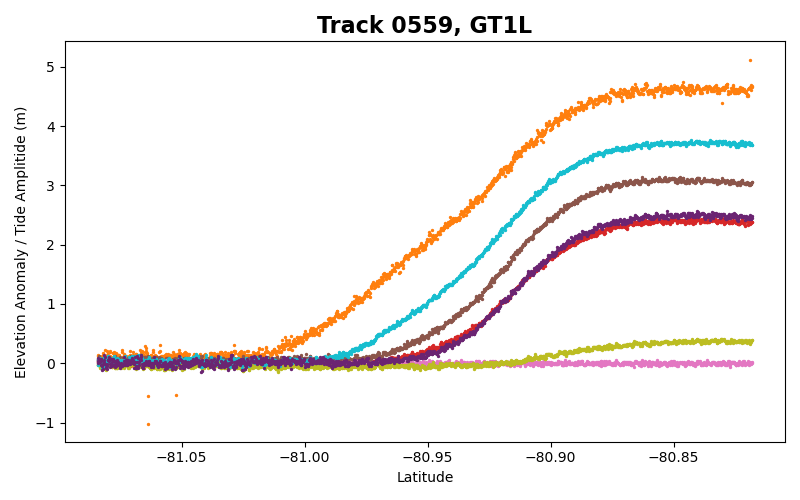

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
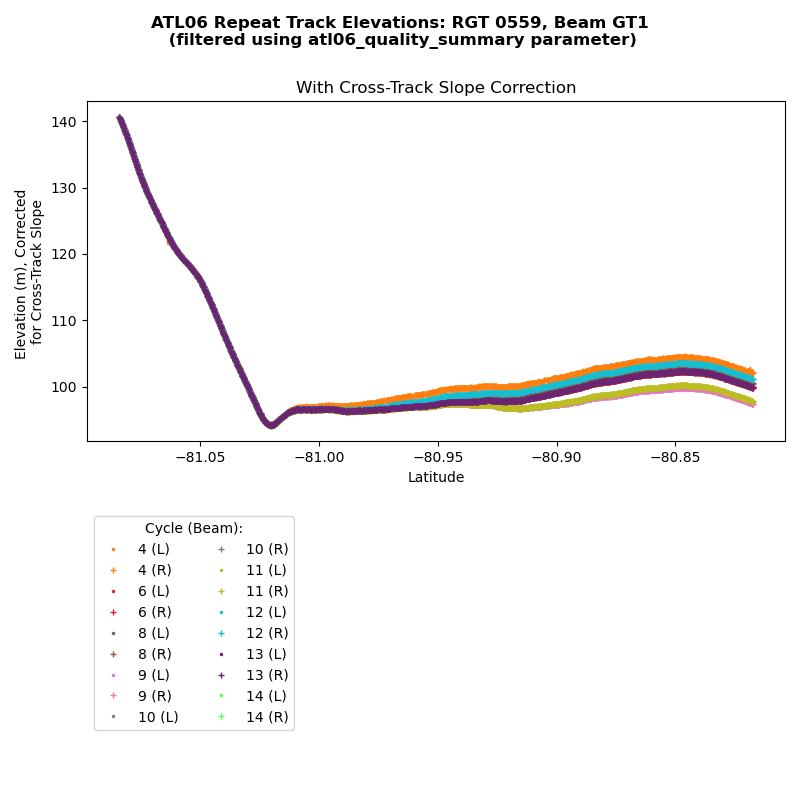

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
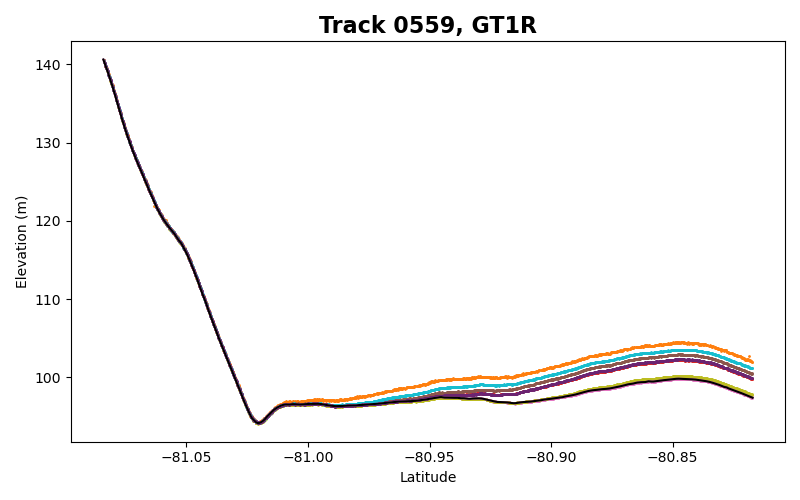

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
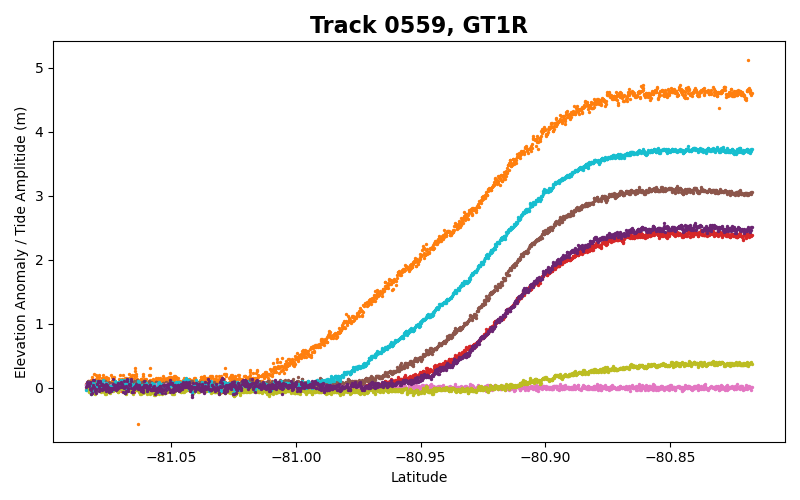

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
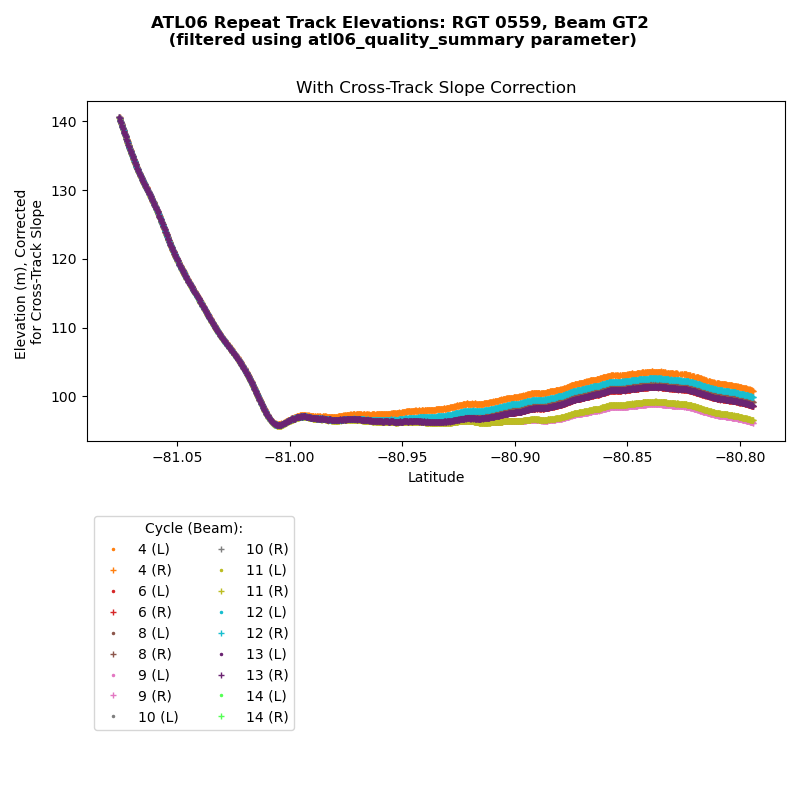

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
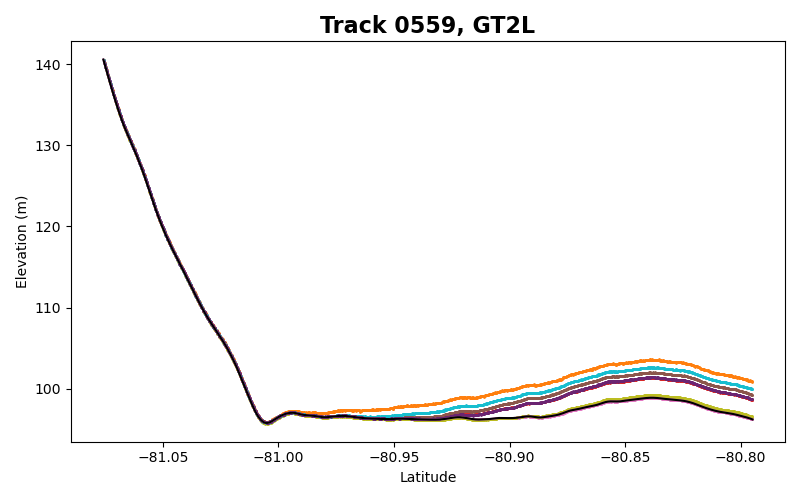

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
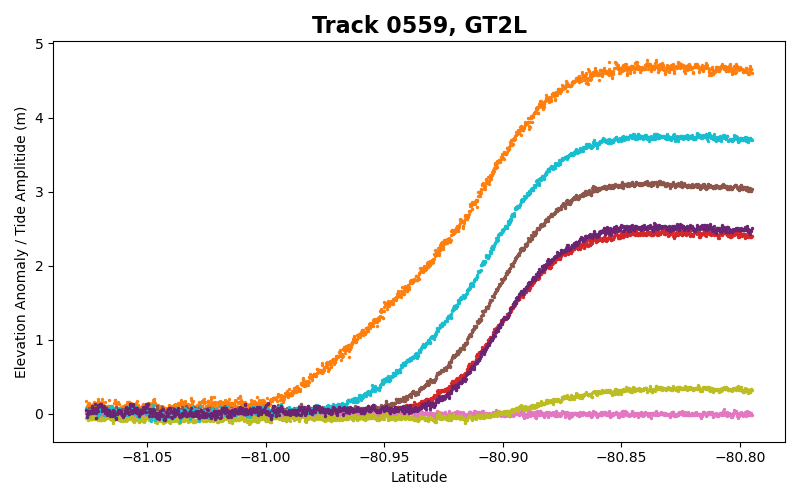

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
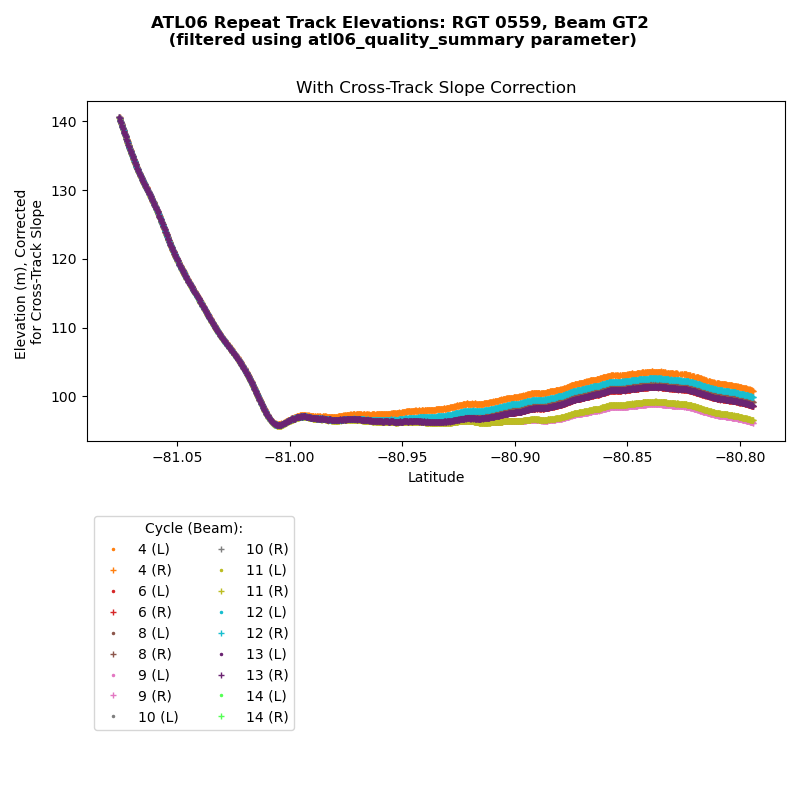

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
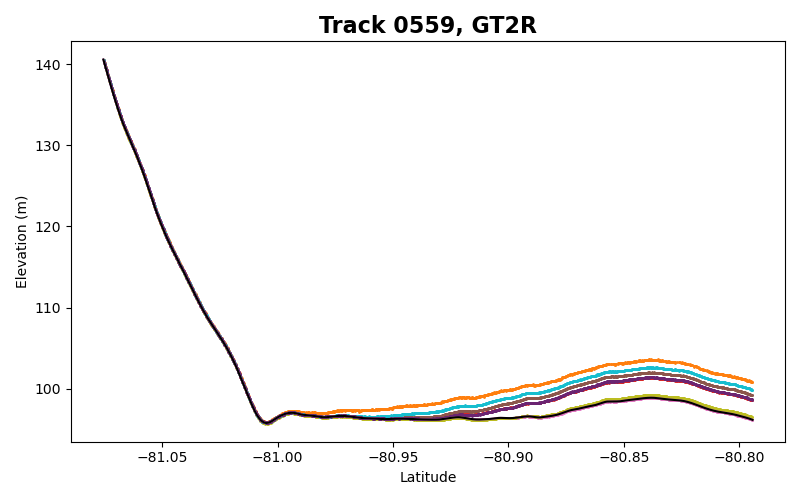

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
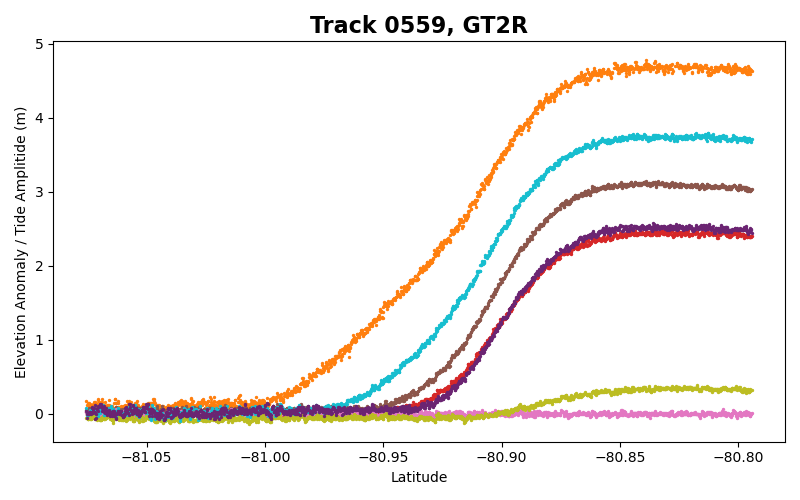

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
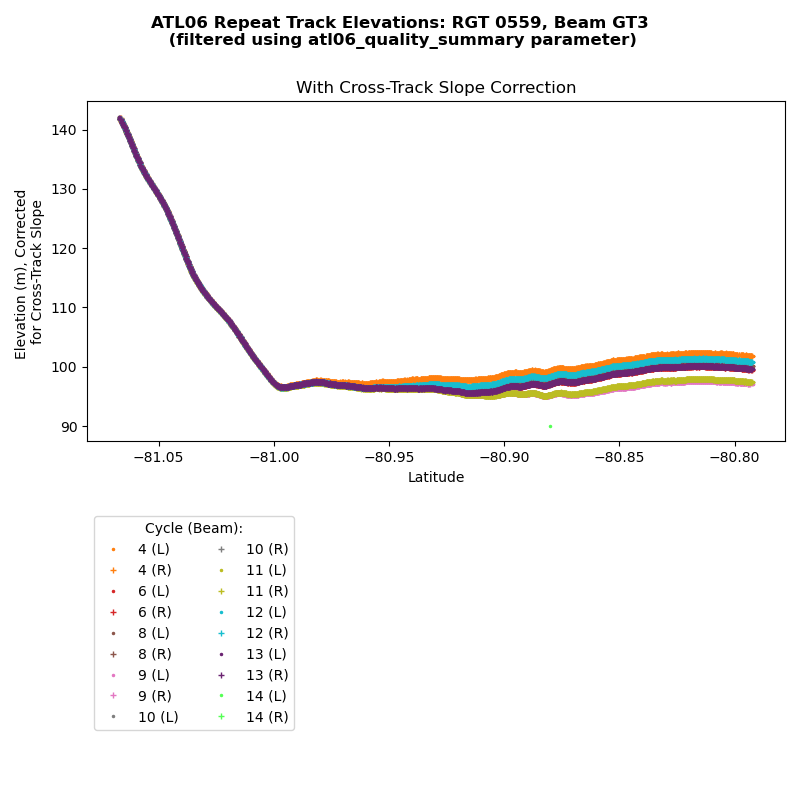

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
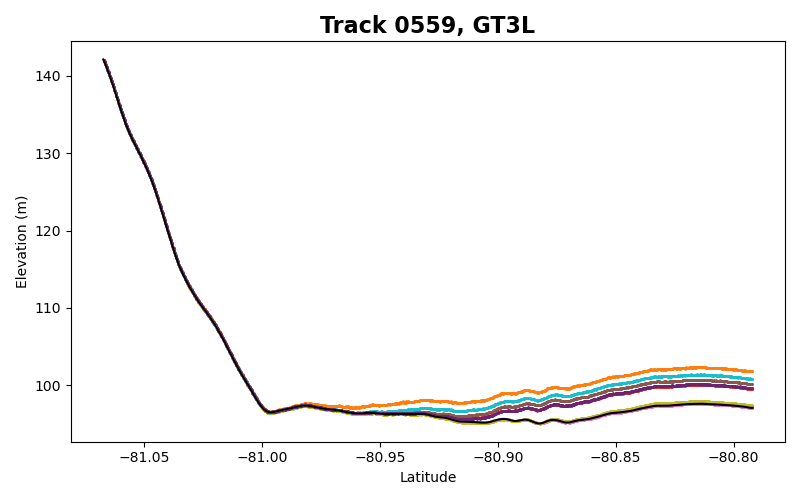

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
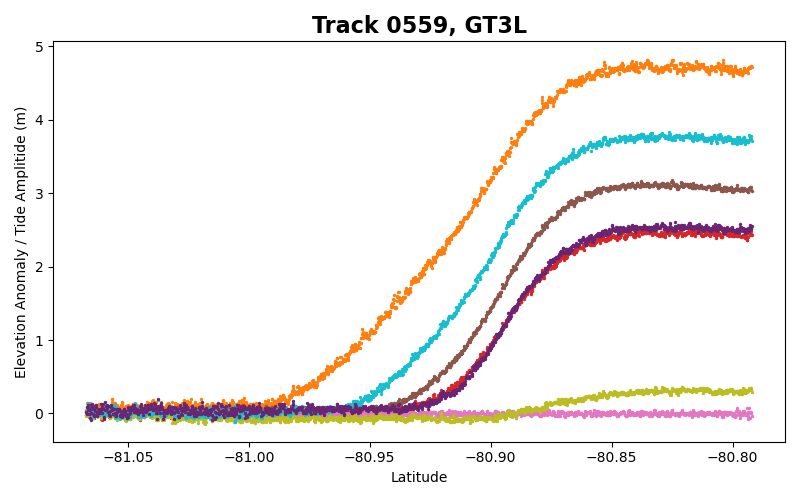

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
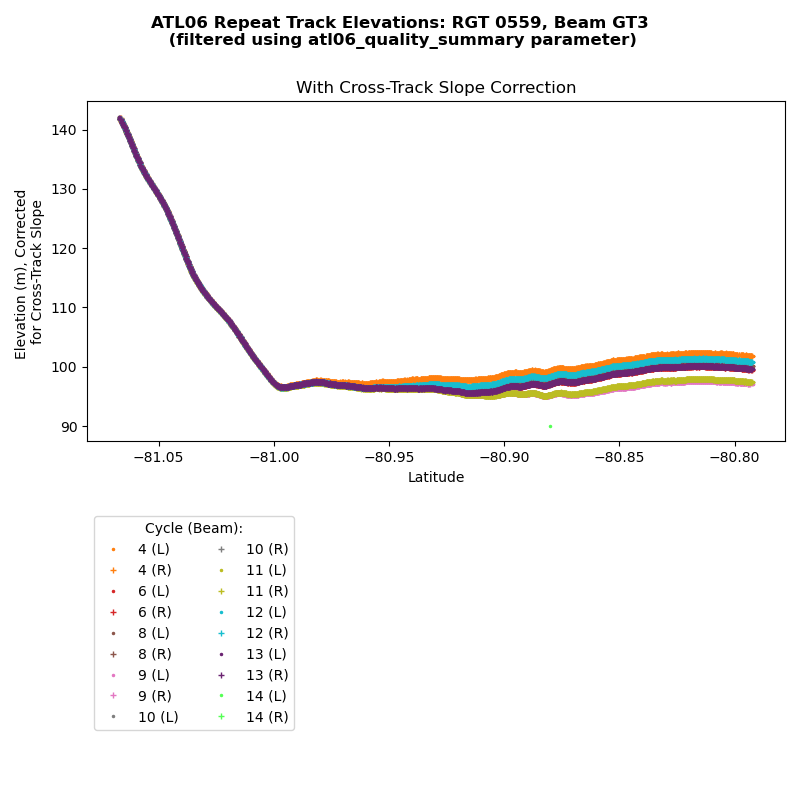

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
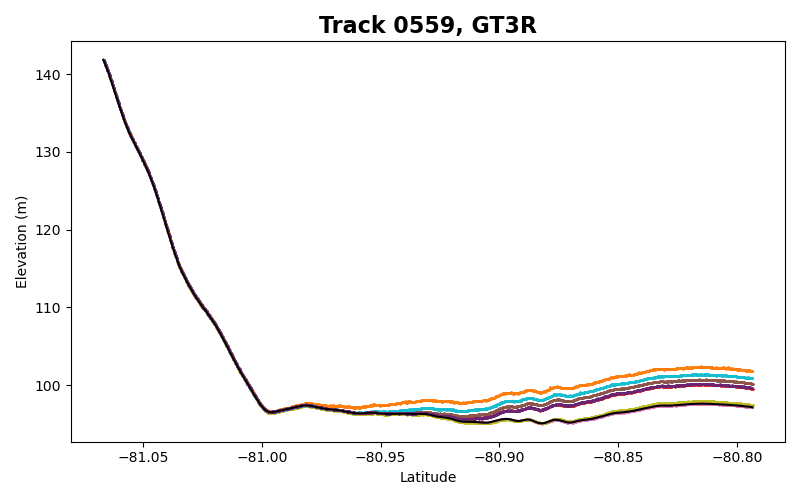

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
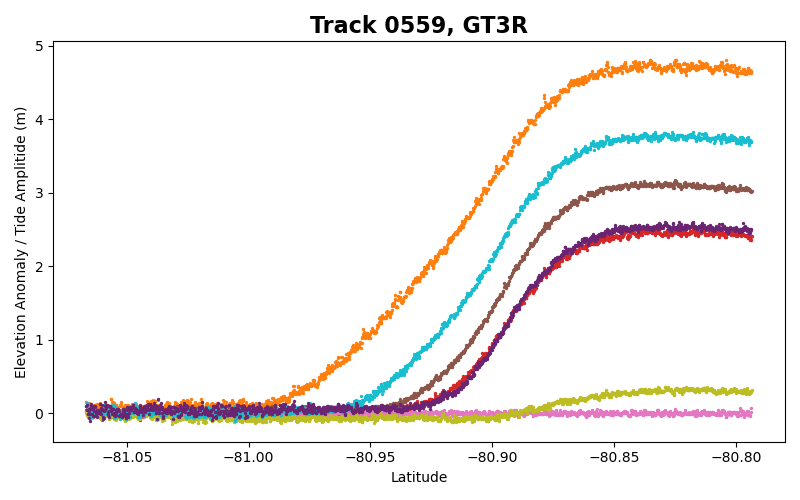

In [66]:
### SCRIPT TO RUN SCRIPT OVER A LIST OF DIFFERENT TRACKS (need to manually adjust any cycles to ignore etc., but good for seeing initial results)

rgts = ['0559'] # List the RGTs to conduct RTLA 

tide_flag = False # Set to True to include modelled tides
tide_position = 'right' # Tide Plotting Options: 'all' plots along-track tides, 'overlap' plots along-track tides just for the last 0.02 lats of tides, 'right' plots tides to right of anomalies

save_flag = False # Set to True to save figures of elevation and anomaly profiles
extra_name = '' # Option to add additional text to output figure names to differentiate particular runs. Default = ''

# Specify Figure Options
figsize=[8,5]
legend = False # Set to True to print legend
plot_ref = True # Set to True to plot the reference line on the elevation profile graph in black

xlim = None # Set x axis limits (elevation and anomaly plots). Default: None
ylim_elev = None # Set ylims for elevation plot. Default: None
ylim_anom = None # Set ylims for anomaly plots. Default: None

# Set choice of reference profile: 
ref = 'lowest' # Options: 'mean', 'neutral', 'lowest'

# Set cycle to be used for reference profile (if using neutral or lowest)
if ref == 'mean':
    ref_cyc = None
    
if ref == 'neutral':
    ref_cyc = '13' # Set to the cycle at neutral tide    
    
if ref == 'lowest':
    print('Using lowest tide cycle as reference profile')
    ref_cyc = '09' # Set the cycle with the lowest tide (either manually or from exported csv using code below)
    
    
# Execute RTLA 
for rgt in rgts: 
    if rgt in []: # Option to include list of RGTs to skip here 
        continue
    repeats = {}
    # Loop through all RPTs and their L and R beams
    for rpt in [1,2,3]:
        for lr in ['l', 'r']:
            
            ## 1. Specify output location by track number
            track_dir = os.path.join(outdir, f'Track{rgt}/') 
            if not os.path.isdir(track_dir):
                os.makedirs(track_dir)
                
            ## 2. Call the PlotCorrectedRepeatTracks function. Applies cross-track correction. Plots initial elevation profile pre-formatting.
            D_l, D_r= PlotCorrectedRepeatTracks(data_root, rgt, rpt, color_dict, cross_track_corr=True)
                
            ## 3. Determine cycles to use in RTLA analysis (leaves out cycles with <50% of data along-track)
            cycles_to_use = [] 
            try:
                thresh = int(max(int(d['lat_corr'].shape[0]) for d in D_l.values()) / 2)
            except ValueError:
                print('Value error, empty file?')
                continue
            else:
                for d in D_l.values():
                    if d['lat_corr'].shape[0] > thresh:
                        cycles_to_use.append(str(d['cycle']).zfill(2))

            # USER INPUT: Option to manually add/remove cycles. Input as list of strings e.g. ['03','04','05']
            cycles_to_ignore = [] # Option to ignore cycles in analysis
            cycles_to_add = [] # Option to add cycles that have been removed 
            cycles_to_ignore_for_mean = [] # Option to ignore cycles in mean calculation
            
            # Determine final version of code to use in analysis and as reference profile
            if ref !='mean':
                cycles_to_ignore_for_mean= [x for x in cycles_to_use if x != ref_cyc] 
            final_cycles = [x for x in set(cycles_to_use) if x not in set(cycles_to_ignore)] + cycles_to_add
            final_cycles.sort(key=float) #sorts list into ascending order
            cycles_for_mean = [x for x in set(final_cycles) if x not in set(cycles_to_ignore_for_mean)]
            print('Cycles to Use: ', final_cycles)
            print('Cycles Used for Mean: ', cycles_for_mean)
            fn = f'{cycles_dir}/used_cycles_{rgt}.txt'
            fn_mean = f'{cycles_dir}/used_cycles_mean_{rgt}.txt'
            if os.path.isfile(fn):
                os.remove(fn)
            if os.path.isfile(fn_mean):
                os.remove(fn_mean)
            with open(fn, 'w') as filehandle:
                for cycle in final_cycles:
                        filehandle.write('%s\n' % cycle)
            with open(fn_mean, 'w') as filehandle:
                for cycle in cycles_for_mean:
                    filehandle.write('%s\n' % cycle)
            
            ## 4. Call the ExtractData() function to make dictionary of repeat tracks  
            if lr == 'l': 
                dict_repeats = ExtractData(D_l, final_cycles, rgt, rpt, lr, data_root, tides=tide_flag)
            elif lr == 'r': 
                dict_repeats = ExtractData(D_r, final_cycles, rgt, rpt, lr, data_root, tides=tide_flag)

            ## 5. Call the CalculateFits() function 
            dict_repeats = CalculateFits(dict_repeats, final_cycles, cycles_for_mean, s=0.7, ref=ref,ref_cyc=ref_cyc,tides=tide_flag, extract_bed=False,bed=None)

            ## 6. PLOTTING
            #a) Plot elevation profile
            PlotElevProfile(dict_repeats, final_cycles, cycles_for_mean, track_dir, color_dict,xlim=xlim,ylim=ylim_elev, plot_fits=True, plot_bed=False, plot_ref=plot_ref,save_fig=save_flag, legend=legend,figsize=figsize,ref=ref,ref_cyc=ref_cyc,extra_name=extra_name)

            #b) Plot elevation anomoaly profile
            PlotElevAnom(dict_repeats, final_cycles, color_dict, track_dir,xlim=xlim,ylim=ylim_anom,plot_bed=False, plot_tide=tide_flag,tide_position=tide_position, plot_axhline=False, save_fig=save_flag, legend=legend,figsize=figsize,ref=ref,ref_cyc=ref_cyc,extra_name=extra_name)
             

#### EXTRA: Code to auto identify cycle with lowest elevation anomaly 

Code to identify the lowest tide track from the anomaly plots by identifying the cycle with the lowest value: 

Finds the cycle with the lowest absolute anomaly value in the last 50 values in the array (most seaward points along-track, beyond point H. *Note - sometimes we have to swap the array slicing from [50:] to [:50] depending on the orientation of the array to ensure it is capturing the seaward end of the track.*

Can loop through all RGTs here and export to CSV to be re-used.

In [23]:
min_anom = {} 
for cycle in final_cycles:
    last_50 = dict_repeats[cycle]['anom'][:50] 
    min_anom[cycle] = min(last_50) 
    print(cycle, min(last_50))
lowest = min(min_anom, key = min_anom.get)
print('Cycle with Lowest Elevation Anomaly over the ice shelf: ', lowest)

04 4.592067027556368
06 2.3517124505325313
08 3.0145383793571625
09 -0.05143408835826335
11 0.26281529596339226
12 3.6510899496969103
13 2.4487914489182003
Cycle with Lowest Elevation Anomaly over the ice shelf:  09


### 4. Per RGT, plot elevation anomalies for individual cycles against the reference cycle. 

We use this code to extract elevation anomalies per cycle, calculated against a mean/neutral/lowest reference profile, for each RGT. 

#### Inputs 
Recommended default flags to start with: 
* tide_flag = False 
* save_flag = False *(Switch on when figure has been checked)*
* export_csv = True *(Need to export to be used to find F locations)* 
* xlim=None 
* ylim=None 
* figsize=[8,5]
* legend=False

#### Outputs
This code needs to be run to export **Track{rgt}_GT{rpt}_cyc{c}_lowest{lowest}.csv** file that used to extract the location of Point F. 


filename=../sample_data/FRIS/data\processed_ATL06_20200502042014_05590711_005_01.h5, exception='Unable to open object (component not found)'
../sample_data/FRIS/results/Track0559/Track0559_GT3L_repeats_anom___cycs0409_lowest.png
../sample_data/FRIS/results/Track0559/Track0559_GT3L_repeats_anom___cycs0609_lowest.png
../sample_data/FRIS/results/Track0559/Track0559_GT3L_repeats_anom___cycs0809_lowest.png
../sample_data/FRIS/results/Track0559/Track0559_GT3L_repeats_anom___cycs0909_lowest.png
../sample_data/FRIS/results/Track0559/Track0559_GT3L_repeats_anom___cycs1109_lowest.png
../sample_data/FRIS/results/Track0559/Track0559_GT3L_repeats_anom___cycs1209_lowest.png
../sample_data/FRIS/results/Track0559/Track0559_GT3L_repeats_anom___cycs1309_lowest.png


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
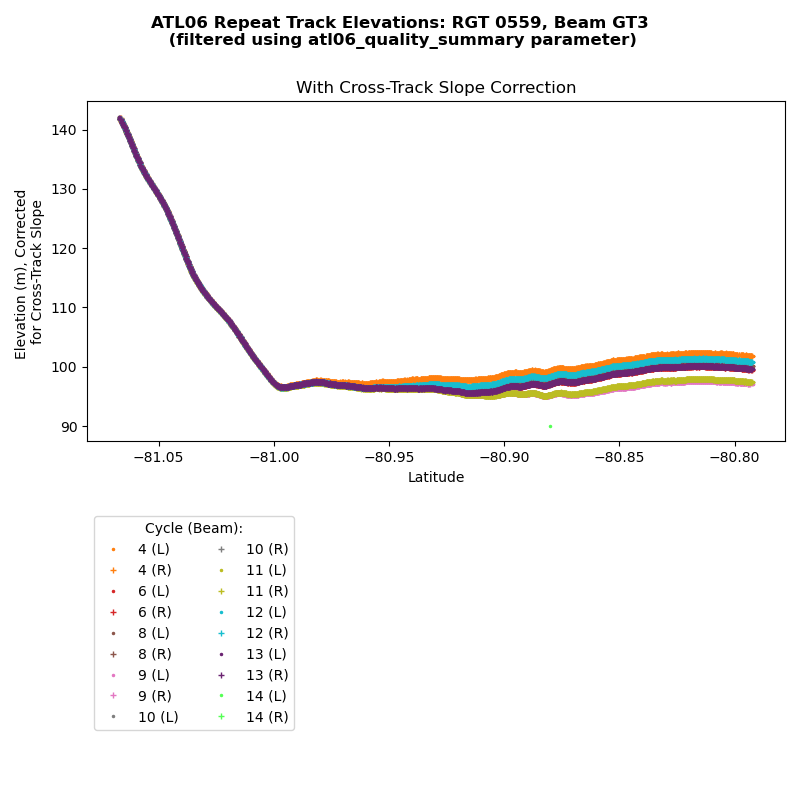

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
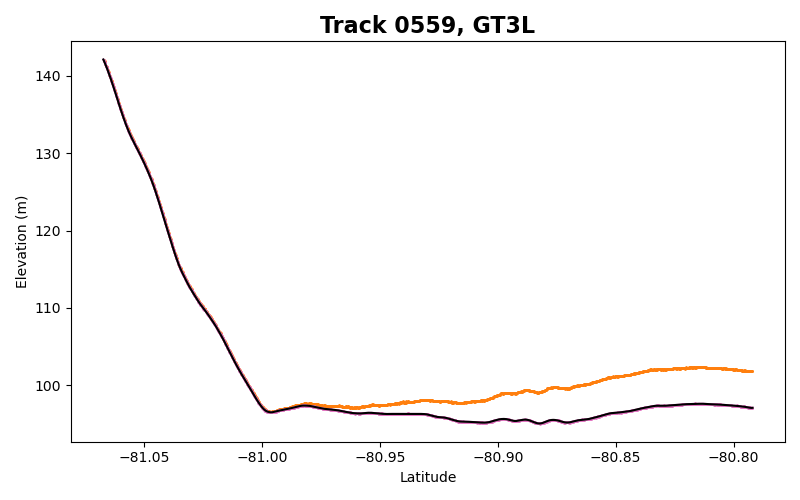

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
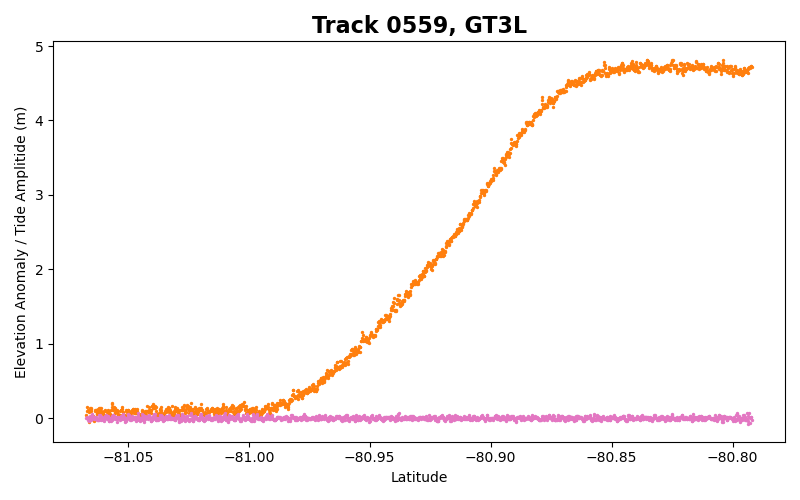

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
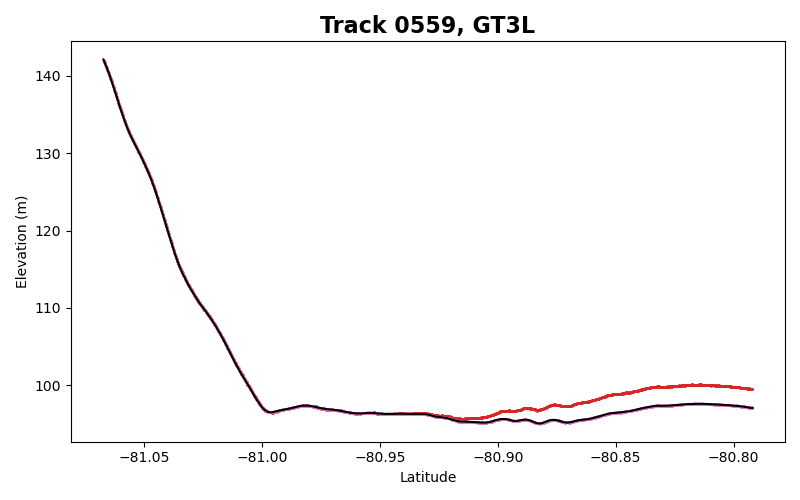

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
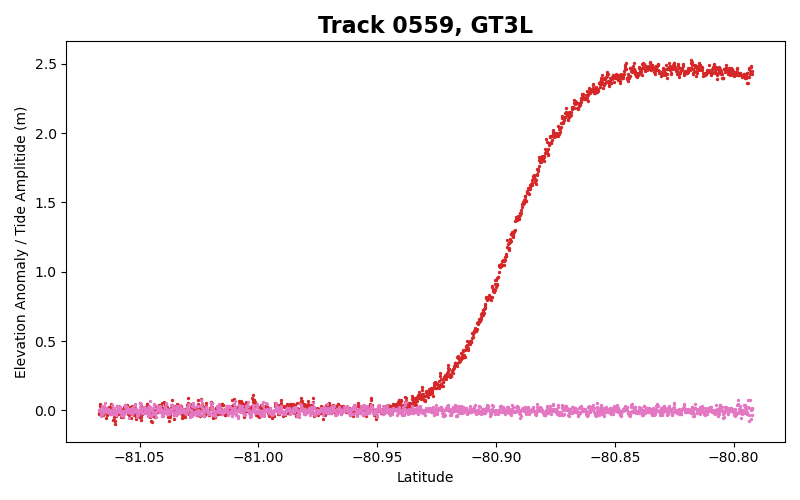

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
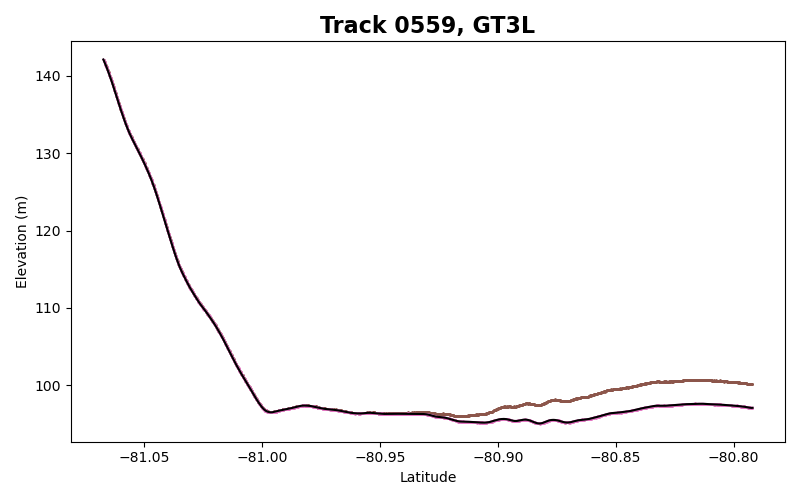

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
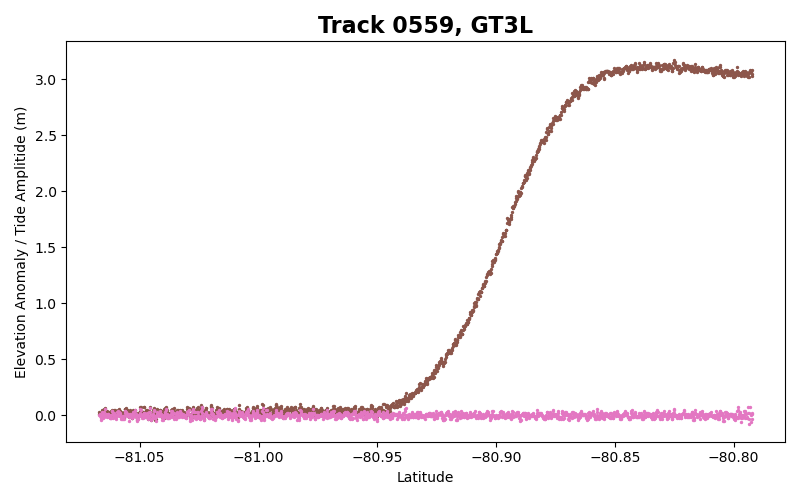

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
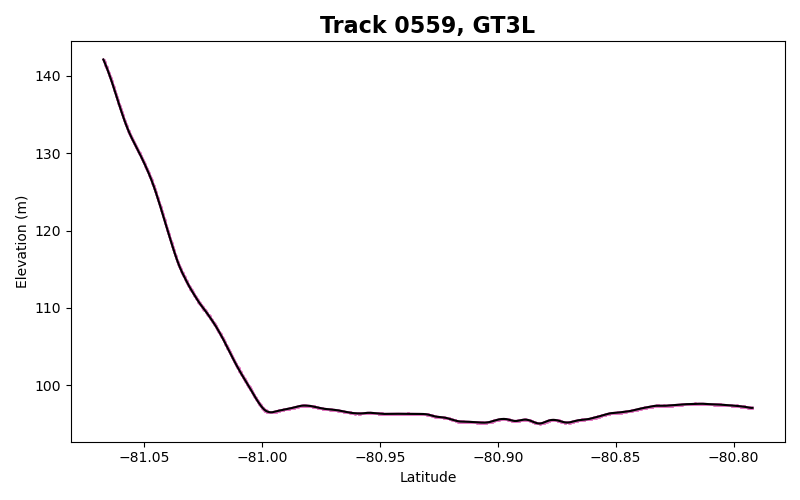

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
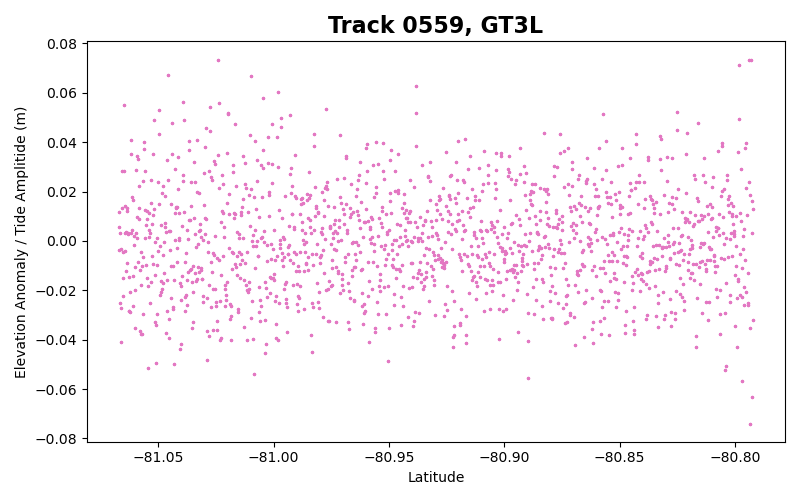

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
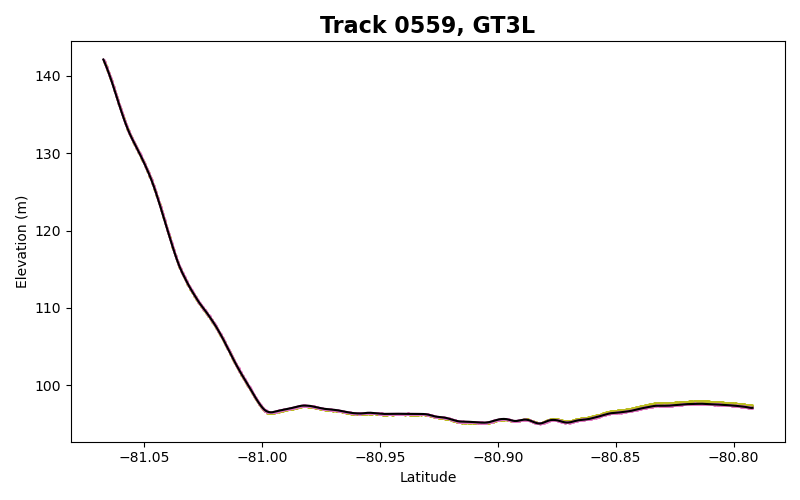

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
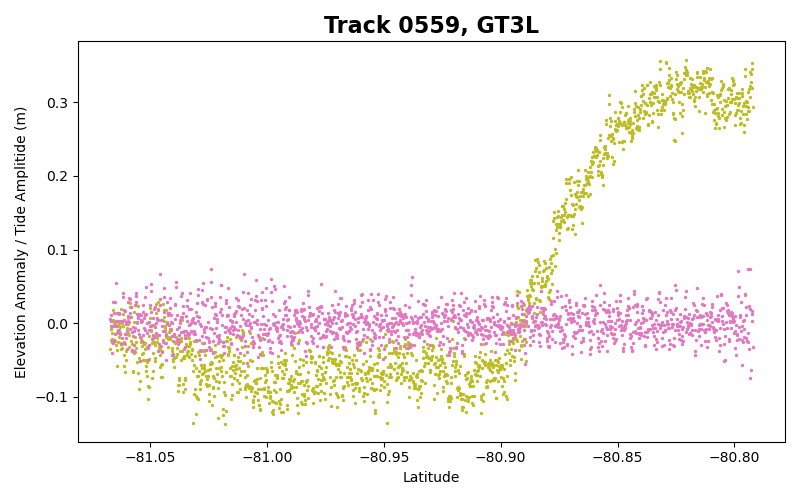

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
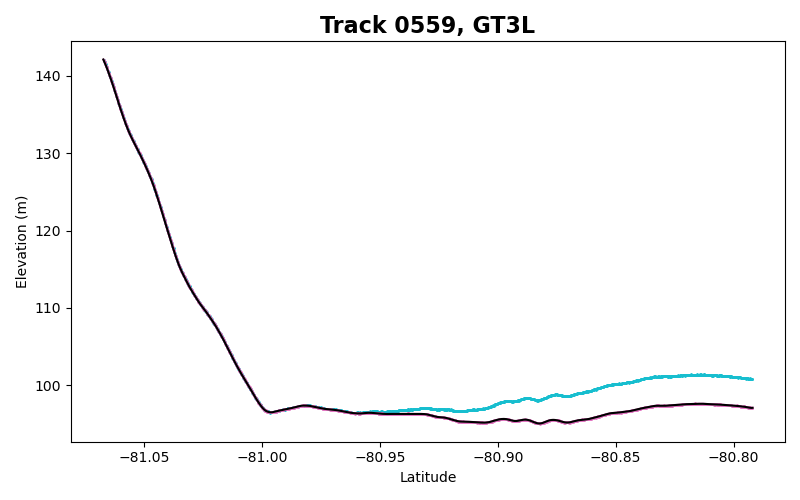

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
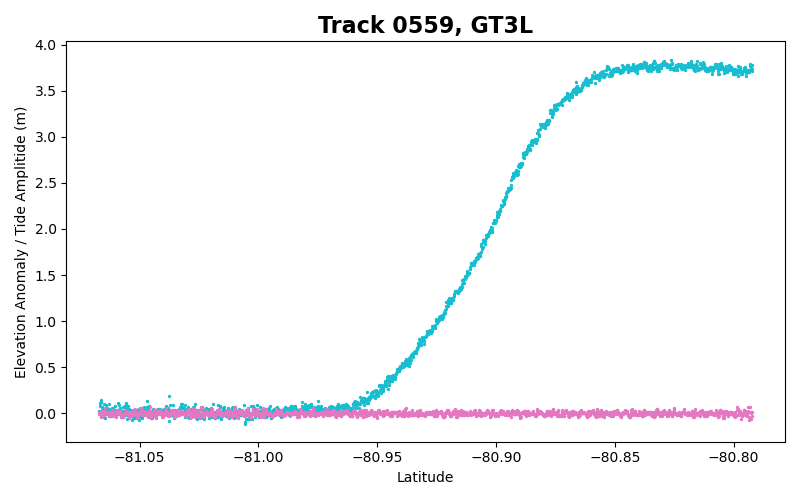

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
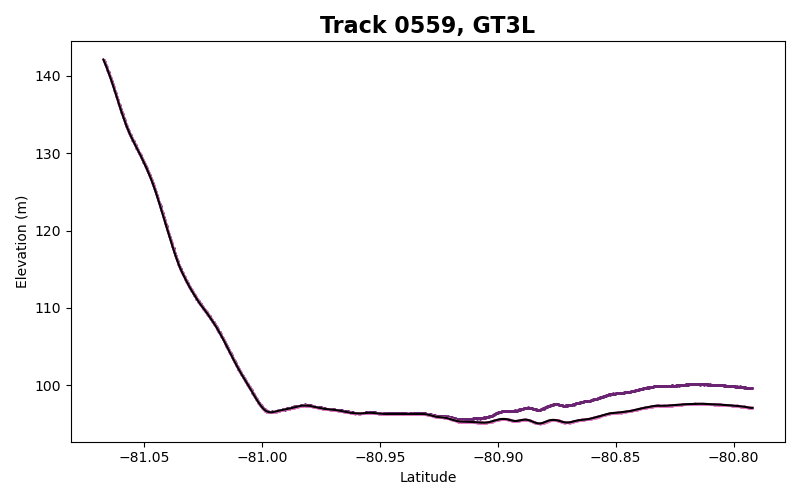

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
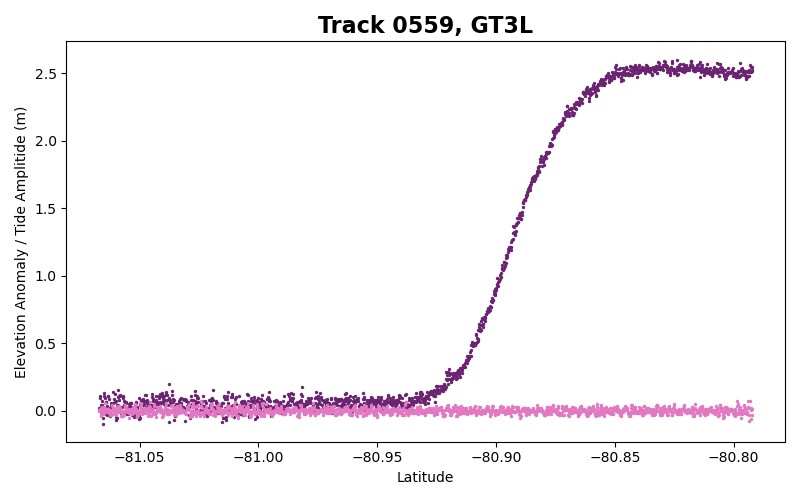

In [68]:
## Option to re-assign user inputs 

rgts = ['0559']

tide_flag = False # Set to True to include modelled tides
tide_position = 'all' # Tide Plotting Options: 'all' plots along-track tides, 'overlap' plots along-track tides just for the last 0.02 lats of tides, 'right' plots tides to right of anomalies
plot_ref = True #set to True to plot the reference line on the elevation profile graph in black

save_flag = True # Set to True to save figures of elevation and anomaly profiles
extra_name = '' # Option to add additional text to output figure names to differentiate particular runs. Default = '' 

export_csv = False # Set to True to export csv of elevation anomalies per cycle 

# Specify Figure Options
figsize=[8,5]
legend = False # Set to True to print legend
xlim = None # Set x axis limits (elevation and anomaly plots). Default: None
ylim_elev = None # Set ylims for elevation plot. Default: None
ylim_anom = None # Set ylims for anomaly plots. Default: None


# Set choice of reference profile 
ref = 'lowest' #'mean' or 'neutral' or 'lowest'

#Set cycle to be used for reference profile (if using neutral or lowest)
if ref == 'lowest':
    ref_cyc = '09' # Set manually per RGT, or extract from automatically determined lowest tide csv

if ref == 'neutral':
    ref_cyc='11' 

if ref == 'mean':
    ref_cyc=None
    
for rgt in rgts:
    for rpt in [1,2,3]:
        for lr in ['l']: 
            ## 1. Specify output location by track number
            track_dir = os.path.join(outdir, f'Track{rgt}/')
            if not os.path.isdir(track_dir):
                os.makedirs(track_dir)
                
            ## 2. Call the PlotCorrectedRepeatTracks function. Applies cross-track correction, gives preliminary elevation plot.
            D_l, D_r= PlotCorrectedRepeatTracks(data_root, rgt, rpt, color_dict, cross_track_corr=True)
                
            ## 3. Determine which cycles to use in RTLA analysis. 
            cycles_to_use = [] 
            try:
                thresh = int(max(int(d['lat_corr'].shape[0]) for d in D_l.values()) / 2)
            except ValueError:
                print('Value error, empty file?')
                continue
            else:
                for d in D_l.values():
                    if d['lat_corr'].shape[0] > thresh:
                        cycles_to_use.append(str(d['cycle']).zfill(2))

            # Calculate anomalies for each cycle against the reference profile 
            for c in cycles_to_use:
                cycles_to_ignore = [x for x in cycles_to_use if x != c]
                cycles_to_add = [] 
                cycles_to_ignore_for_mean = [x for x in cycles_to_use if x != ref_cyc]
                final_cycles = [x for x in set(cycles_to_use) if x not in set(cycles_to_ignore)] + cycles_to_add
                final_cycles.sort(key=float) 
                cycles_for_mean = [x for x in set(cycles_to_use) if x not in set(cycles_to_ignore_for_mean)]
                final_cycles.append(cycles_for_mean[0])

                ## 4. Call the ExtractData() function to make dictionary of repeat tracks  
                if lr == 'l': 
                    dict_repeats = ExtractData(D_l, final_cycles, rgt, rpt, lr, data_root, tides=tide_flag)
                elif lr == 'r': 
                    dict_repeats = ExtractData(D_r, final_cycles, rgt, rpt, lr, data_root, tides=tide_flag)

                ## 5. Call the CalculateFits() function
                dict_repeats = CalculateFits(dict_repeats, final_cycles, cycles_for_mean, s=0.7, ref=ref,ref_cyc=ref_cyc,tides=tide_flag, extract_bed=False,bed=None)
                
                ## 6. PLOTTING
                #a) Plot elevation profile (extra options: plot fits per cycle, plot bed elevation on subplot, save figure) #Can add , ylim=120
                PlotElevProfile(dict_repeats, final_cycles, cycles_for_mean, track_dir, color_dict,xlim=xlim, ylim=ylim_elev,plot_fits=True, plot_bed=False, save_fig=save_flag, legend=legend,figsize=figsize,ref=ref,ref_cyc=ref_cyc,extra_name=extra_name)
                
                #b) Plot elevation anomoaly profile (extra options: plot fits per cycle, plot bed elevation on subplot, save figure) ,ylim=[-0.5,0.5]
                PlotElevAnom(dict_repeats, final_cycles, color_dict, track_dir,xlim=xlim,ylim=ylim_anom,plot_bed=False, plot_tide=tide_flag,tide_position=tide_position, save_fig=save_flag, legend=legend,figsize=figsize,ref=ref,ref_cyc=ref_cyc,extra_name=extra_name)
                
                ## 7. Save CSV of Anomalies per Cycle                   
                if export_csv == True:
                    export = dict((key, dict_repeats[c][key]) for key in ['lat_corr','lon_corr', 'anom'])
                    df = pd.DataFrame.from_dict(export)
                    csv_name = f'{outdir}Track{rgt}/Track{rgt}_GT{rpt}{lr.upper()}_cyc{c}_{ref}{ref_cyc}_v1.csv'
                    
                    attempts = 0
                    while attempts < 3:
                        try:
                            df.to_csv(csv_name)
                            break
                        except OSError as e:
                            attempts += 1
                            csv_name = csv_name[:-4] + '1.csv'
                            print("OSError, Writing new version as ", csv_name)